In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from keras.models import Sequential

from keras.layers.convolutional import Conv2D, MaxPooling2D

from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 구글 드라이브에 있는 파일 및 폴더를 가지고 오기 위해 마운트
from google.colab import drive
drive.mount('/content/data_mini')

Mounted at /content/data_mini


### 데이터 준비(train, validation, test data)


In [ ]:
np.random.seed(3)

In [ ]:
mini_path = '/content/data_mini/MyDrive/data_mini/ramyeon_mini'

In [ ]:
# train data 생성하기
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, 
                                  rotation_range = 30, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1,
                                  shear_range=0.2, 
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  vertical_flip=False, # 수직방향(상하)로 뒤집기
                                  fill_mode='nearest')

# 이미지를 사용할 때마다 임의로 변형을 가함으로써 마치 훨씬 더 많은 이미지를 보고 공부하는 것과 같은 학습 효과를 낸다.
# 이를 통해 과적합, 즉 모델이 학습 데이터에만 맞춰지는 것을 방지하고, 새로운 이미지도 잘 분류할 수 있게 된다.
# 데이터 증강하기 -> 실제 입력될 데이터 수준을 고려하면서 파라미터 수정하기

train_generator = train_datagen.flow_from_directory(
        mini_path+'/train',  
        target_size=(224, 224),  
        batch_size=128, 
        class_mode='categorical')

Found 2559 images belonging to 12 classes.


In [ ]:
# ImageDataGenerator 이후의 데이터 시각화

original_datagen = ImageDataGenerator(rescale = 1./255)
original_generator = original_datagen.flow_from_directory(mini_path+'/train', 
                                                          batch_size=128, 
                                                          target_size=(224, 224), 
                                                          class_mode='categorical'
                                                         )

Found 2559 images belonging to 12 classes.


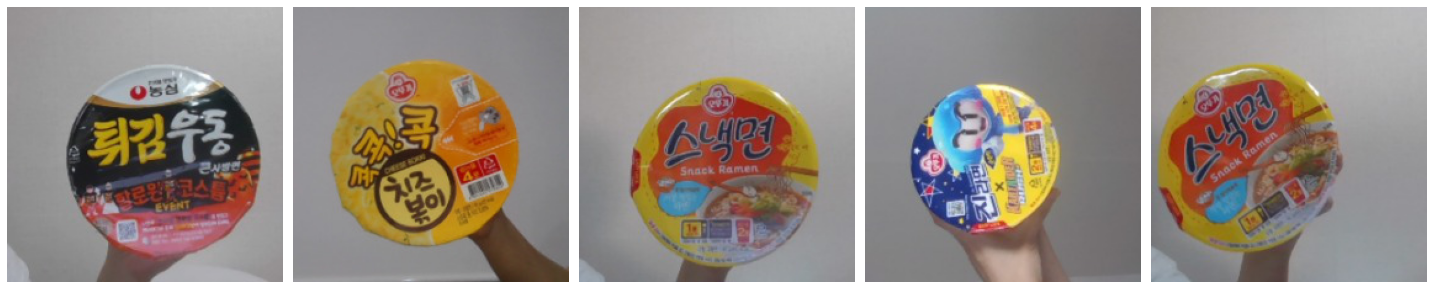

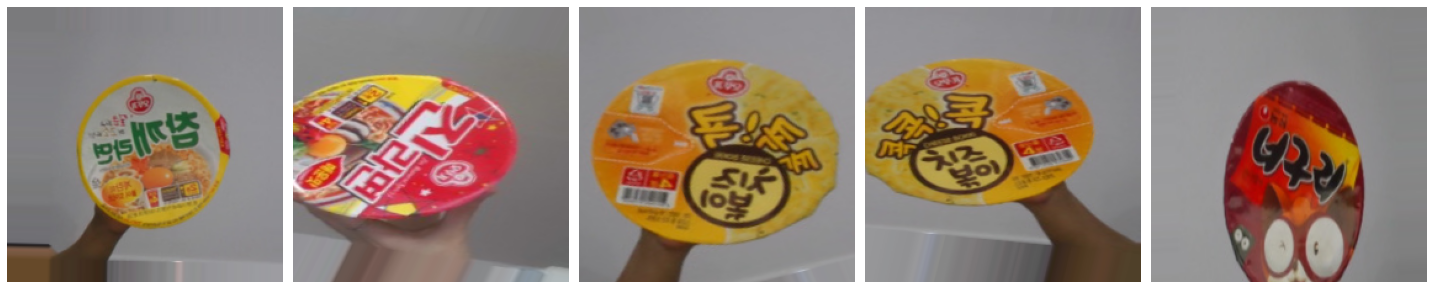

In [ ]:
# 현실에 있을만한 데이터인지 확인하면서 파라미터를 조정해야한다.

original_generator_images, _ = next(original_generator)
train_generator_images, _ = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(original_generator_images[:5])
plotImages(train_generator_images[:5])

# next 함수는 데이터셋의 배치를 반환한다. 
# next 함수의 반환값은 (x_train, y_train) 형태이다. 
# 여기서 x_train은 학습 특징들(픽셀값)이고 y_train은 라벨이다. 
# 학습 데이터만 보여주기 위해서 라벨은 숨긴다

In [ ]:
# validation data 생성

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        mini_path+'/val',
        target_size=(224, 224),    
        class_mode='categorical',
        batch_size=10)

Found 234 images belonging to 12 classes.


## Resnet152V2

In [ ]:
np.random.seed(3)
tf.compat.v1.set_random_seed(3)

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                  rotation_range = 30,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.2,
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        mini_path+'/train',  
        target_size=(224, 224),  
        batch_size=128, 
        class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255.)

validation_datagen = validation_datagen.flow_from_directory(
        mini_path+'/val',
        target_size=(224, 224),    
        batch_size=10,
        class_mode='categorical')

Found 2559 images belonging to 12 classes.
Found 234 images belonging to 12 classes.


In [ ]:
# ResNet152V2 모델 불러오기
transfer_model = tf.keras.applications.ResNet152V2(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
transfer_model.summary()

234561536/234545216 [==============================] - 3s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_____________________

In [ ]:
# for layer in transfer_model.layers:
#   layer.trainable = False
transfer_model.trainable = False

model = models.Sequential()
model.add(transfer_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(12, activation='softmax'))
model.summary()



model.compile(loss='categorical_crossentropy',
                       optimizer=optimizers.Adam(learning_rate=0.01), 
                       metrics=['accuracy'])



history = model.fit_generator(train_generator, epochs=20, validation_data=validation_datagen )



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dense_6 (Dense)              (None, 12)                780       
Total params: 64,755,020
Trainable params: 6,423,372
Non-trainable params: 58,331,648
_________________________________________________________________
Epoch 1/20
20/20 [==============================] - 643s 31s/step - loss: 31.4456 - accuracy: 0.7300 - val_loss: 0.0550 - val_accuracy: 0.9915
Epoch 2/20
20/20 [==============================] - 51s 3s/step - loss: 0.7622 - accuracy

In [ ]:
model.save('Resnet152V2_ramyeon.h5')

In [ ]:
# 모델 불러오기
model = tf.keras.models.load_model('/content/Resnet152V2_ramyeon.h5')

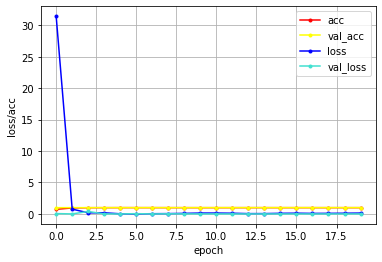

In [ ]:
# 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c='red', label='acc')
plt.plot(x_len, val_acc, marker='.', c='yellow', label='val_acc')
plt.plot(x_len, y_loss, marker='.', c='blue', label='loss')
plt.plot(x_len, y_vloss, marker='.', c='turquoise', label='val_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()


In [ ]:
# 예측에 사용할 데이터(train data 와 비슷한 test data)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        mini_path+'/test',
        target_size=(224, 224),    
        # batch_size=3,
        class_mode='categorical', shuffle=False, seed=0)

# test data 로 모델 평가하기
print()
print("-- Evaluate --")
scores = model.evaluate_generator(test_generator) #steps = 5
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 모델 예측하기
print()
print("-- Predict --")

output = model.predict_generator(test_generator)  # steps = 5
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.3f}".format(x)})

print(test_generator.class_indices)
print(output)

for s in range(0, len(test_generator.filenames)):
  print(test_generator.filenames[s])

Found 24 images belonging to 12 classes.

-- Evaluate --
accuracy: 37.50%

-- Predict --
{'bul_dak': 0, 'cham_kkae': 1, 'cheese': 2, 'jin_hot': 3, 'jin_sun': 4, 'neo_gu_ri': 5, 'sa_ri': 6, 'sae_u_tang': 7, 'snack': 8, 'woo_dong': 9, 'yeul': 10, 'yuk_gae_jang': 11}
[[1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.909 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.091 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.840 0.160 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.00

In [ ]:
# 예측에 사용될 데이터 -> 다른 모델 결과값과의 차이 비교하기
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        mini_path+'/test',
        target_size=(224, 224),    
        # batch_size=3,
        class_mode='categorical', shuffle=False, seed=0)

# test data 로 모델 평가하기
print()
print("-- Evaluate --")
scores = model.evaluate_generator(test_generator) #steps = 5
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 모델 예측하기
print()
print("-- Predict --")

output = model.predict_generator(test_generator)  # steps = 5)
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.3f}".format(x)})

# print(test_generator.class_indices)
print(output)
print(test_generator.filenames)

Found 24 images belonging to 12 classes.

-- Evaluate --
accuracy: 37.50%

-- Predict --
[[1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.909 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.091 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.840 0.160 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.0